In [1]:
import numpy as np
from classy import Class

lcdm = Class()
lcdm.set({
    'output': 'mPk',
    'non linear': 'none',
    'P_k_max_1/Mpc' : 150,
})
lcdm.compute()
ks = np.logspace(-3, 2, 1000)


fs = [0.1, 0.5, 1.0]
pks_f = []
for i, f in enumerate(fs):
    Gf_ref = 0.005
    Gamma = Gf_ref/f
    ddm = Class()
    Omega_dm = lcdm.Omega_m() - lcdm.Omega_b()
    ddm.set(({
        'output': 'mPk',
        'non linear': 'none',
        'P_k_max_1/Mpc' : ks[-1],
        'Omega_ini_dcdm' : Omega_dm * f,
        'Omega_cdm' : Omega_dm * (1-f),
        'Gamma_dcdm' : 977.792 * Gamma
    }))
    ddm.compute()
    pks_f.append(np.vectorize(ddm.pk_lin)(ks * lcdm.h(), 0) / np.vectorize(lcdm.pk_lin)(ks * lcdm.h(), 0))

Gfs = [0.001, 0.005, 0.01]
pks_gf = []
for i, Gf in enumerate(Gfs):
    f_ref = 0.5
    Gamma = Gf/f_ref
    ddm = Class()
    Omega_dm = lcdm.Omega_m() - lcdm.Omega_b()
    ddm.set(({
        'output': 'mPk',
        'non linear': 'none',
        'P_k_max_1/Mpc' : ks[-1],
        'Omega_ini_dcdm' : Omega_dm * f,
        'Omega_cdm' : Omega_dm * (1-f),
        'Gamma_dcdm' : 977.792 * Gamma
    }))
    ddm.compute()
    pks_gf.append(np.vectorize(ddm.pk_lin)(ks * lcdm.h(), 0) / np.vectorize(lcdm.pk_lin)(ks * lcdm.h(), 0))

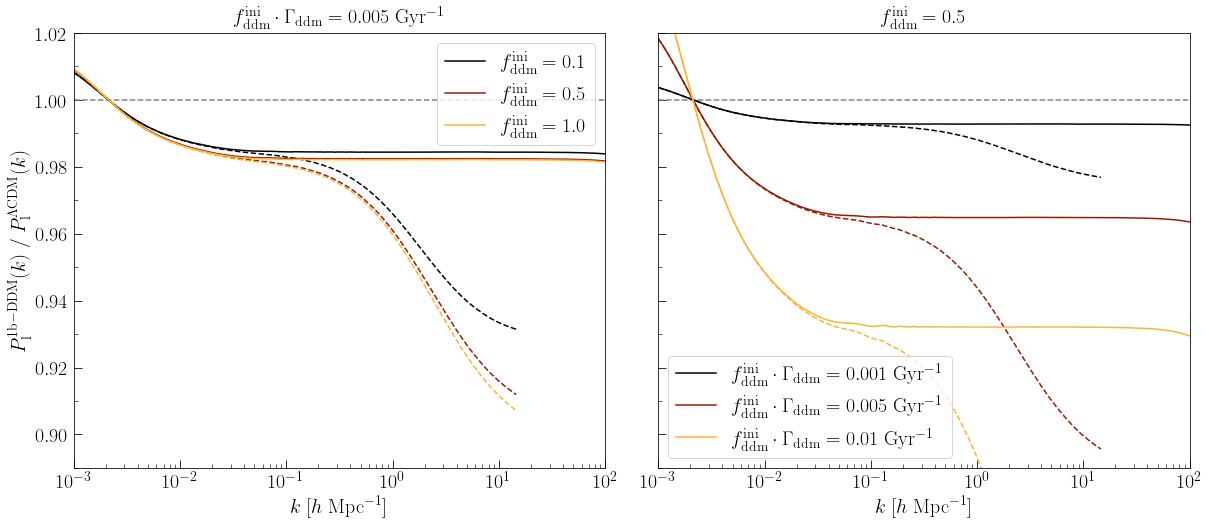

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl

def nl_suppression(cosmo,G,f,k,z):    

    h = cosmo.h()
    omega_m = cosmo.Omega_m()*h**2
    omega_b = cosmo.omega_b()
    u = omega_b/0.02216
    v = h/0.6776
    w = omega_m/0.14116

    a = 0.7208 + 2.027 * G + 3.0310*(1/(1+1.1*z))-0.18
    b = 0.0120 + 2.786 * G + 0.6699*(1/(1+1.1*z))-0.09
    p = 1.045 + 1.225  * G + 0.2207*(1/(1+1.1*z))-0.099
    q = 0.9922 + 1.735 * G + 0.2154*(1/(1+1.1*z))-0.056
    
    alpha = (5.323 - 1.4644*u - 1.391*v) + (-2.055+1.329*u+0.8673*v)*w + (0.2682-0.3509*u)*w**2
    beta  = (0.9260) + (0.05735 - 0.02690*v)*w + (-0.01373 + 0.006713*v)*w**2
    gamma = (9.553 - 0.7860*v)+(0.4884+0.1754*v)*w + (-0.2512+0.07558*v)*w**2

    epsilon_lin = alpha * (G)**beta * (1/(0.105*z + 1))**gamma
    ratio = (1+a*k**p)/(1+b*k**q)*f

    return (1.-epsilon_lin * ratio)/(1.-epsilon_lin*f)

mpl.rcParams['text.usetex'] = True


fontsize = 20
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth (20)


ax1.set_title(r"$f_\mathrm{ddm}^\mathrm{ini}\cdot\Gamma_\mathrm{ddm} = %s\mathrm{\;Gyr^{-1}}$" % Gf_ref, fontsize=fontsize, pad=10)
ax1.set_ylabel(r"$P_\mathrm{l}^\mathrm{1b-DDM}(k)\;/\;P_\mathrm{l}^{\Lambda\mathrm{CDM}}(k)$", fontsize=fontsize)
ax1.set_xlabel(r"$k\; [h\mathrm{\;Mpc}^{-1}]$", fontsize=fontsize)
ax1.set_xlim(ks[0], ks[-1])
ax1.set_ylim(0.89,1.02)
ax1.set_xscale("log")

ax2.set_title(r"$f_\mathrm{ddm}^\mathrm{ini}=%s$" % f_ref, fontsize=fontsize, pad=10)
ax2.set_xlabel(r"$k\; [h\mathrm{\;Mpc}^{-1}]$", fontsize=fontsize)
ax2.set_xlim(ks[0], ks[-1])
ax2.set_ylim(0.89,1.02)
ax2.set_xscale("log")

ax1.hlines(1, ks[0], ks[-1], linestyles="dashed", color="grey")
ax2.hlines(1, ks[0], ks[-1], linestyles="dashed", color="grey")

kmax_emulator = 10 / lcdm.h()

colours = pl.cm.afmhot(np.linspace(0,0.6,len(fs)))
for i, pk in enumerate(pks_f):
    ax1.plot(
        ks,
        pk,
        label="$f_\mathrm{ddm}^\mathrm{ini} = %s$" % fs[i],
        color=colours[i]
    )
    ax1.plot(
        ks[np.where(ks<kmax_emulator)],
        # OBD.predict(
        #     ks[np.where(ks<kmax_emulator)] * lcdm.h(),
        #     float(0),
        #     Gf_ref / fs[i],
        #     fs[i],
        #     lcdm.Omega_b(),
        #     lcdm.Omega_m(),
        #     lcdm.h()
        # ) * pk[np.where(ks<kmax_emulator)],
        # color=colours[i],
        nl_suppression (lcdm, Gf_ref / fs[i], fs[i], ks[np.where(ks<kmax_emulator)] * lcdm.h(), 0) * pk[np.where(ks<kmax_emulator)],
        color=colours[i],
        linestyle="dashed"
    )

colours = pl.cm.afmhot(np.linspace(0,0.6,len(Gfs)))
for i, pk in enumerate(pks_gf):
    ax2.plot(
        ks,
        pk,
        label="$f_\mathrm{ddm}^\mathrm{ini}\cdot\Gamma_\mathrm{ddm} = %s\mathrm{\;Gyr^{-1}}$" % Gfs[i],
        color=colours[i],
    )
    ax2.plot(
        ks[np.where(ks<kmax_emulator)],
        nl_suppression (lcdm, Gfs[i] / f_ref, f_ref, ks[np.where(ks<kmax_emulator)] * lcdm.h(), 0) * pk[np.where(ks<kmax_emulator)],
        color=colours[i],
        linestyle="dashed"
    )

ax1.legend(fontsize=fontsize)
ax2.legend(fontsize=fontsize)
ticks = [0.90, 0.92, 0.94, 0.96, 0.98, 1.00, 1.02]
ticks_labels = ["$0.90$", "$0.92$", "$0.94$", "$0.96$", "$0.98$", "$1.00$", "$1.02$"]
ticks_minor = [0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01]
empty = ["", "", "", "", "", "", ""]
empty_minor = ["", "", "", "", "", "", ""]
ax1.set_yticks(ticks, ticks_labels, fontsize=fontsize)
ax1.set_yticks(ticks_minor, empty_minor, minor=True)
ax2.set_yticks(ticks, empty, fontsize=fontsize)
ax2.set_yticks(ticks_minor, empty_minor, minor=True)
ax1.tick_params(length=8, labelsize=fontsize)
ax1.tick_params(length=4, labelsize=fontsize, which="minor")
ax1.tick_params(direction='in', which="both", pad=6)
ax2.tick_params(length=8, labelsize=fontsize)
ax2.tick_params(length=4, labelsize=fontsize, which="minor")
ax2.tick_params(direction='in', which="both", pad=6)

plt.subplots_adjust(wspace=0.1)

fig.savefig("/home/justus/Uni/plots/pk_lin/1b.pdf", bbox_inches = "tight")